# Script de Geração do Template de Resultados do Focus

Execução do Código:

* Entra no site do BC e baixa o documento do focus da segunda respectiva;
* Lê o PDF e separa os dados de interesse;
* Por fim os dados são adicionados ao template.

Pontos de Atenção:

* Modificar "base_path" e "download_directory" de acordo com seu PC;
* Pode ser que ao ler o PDF os números venham com espaços enter os dígitos ou algo similar. O código não consegue lidar com esse tipo de erro, neste caso sugere-se alterar o template original.

Link template original: https://www.canva.com/design/DAFo6BHnFLo/wSjpGwHscBFz2tyPrBT44w/edit

# 0. Import Libraries

In [1]:
import os
import openpyxl
import locale
import PyPDF2
import requests
import pandas as pd

from io import BytesIO
from bcb import Expectativas
from datetime import datetime, timedelta
from PIL import Image, ImageDraw, ImageFont

## Warnings Off
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Paths
base_path = r'Grupo GCB\GCB CAPITAL - Investimentos\GCB Capital1\\'
# base_path = r'Grupo GCB\GCB CAPITAL - Documentos\Investimentos\GCB Capital1\\'

backoffice_path = os.path.join(os.path.expanduser("~"), base_path + r"Backoffice\\")

image_path = os.path.join(os.path.expanduser("~"), backoffice_path + r"Conteudo_Divulgacao\Templates\\")
saving_path = os.path.join(os.path.expanduser("~"), backoffice_path + r"Conteudo_Divulgacao\Imagens\\")

## Set Locale
locale.setlocale(locale.LC_ALL, 'pt_BR')

## Day
today = datetime.today().strftime('%Y%m%d')

curr_year = datetime.today().year
next_year = curr_year + 1
print(today)

20240416


# 1. Collect Focus Data

In [3]:
def get_last_friday():
    today = datetime.today()
    today_weekday = today.weekday()  # Monday is 0, Sunday is 6
    
    # Calculate the number of days to subtract to get to the last Friday (weekday 4)
    days_difference = today_weekday - 4 if today_weekday >= 4 else today_weekday + 3

    # Subtract the calculated days to get the date of the last Friday
    last_friday = today - timedelta(days=days_difference)

    return last_friday

In [4]:
# Set the URL of the PDF
last_friday = get_last_friday().strftime('%Y%m%d')
# last_friday = get_last_friday().strftime('20240328')
pdf_url = f'https://www.bcb.gov.br/content/focus/focus/R{last_friday}.pdf'

# Set the download directory
download_directory = r"C:\Users\andre.huang\Grupo GCB\GCB CAPITAL - Investimentos\GCB Capital1\Backoffice\Conteudo_Divulgacao\Focus Reports"
# download_directory = r"C:\Users\CarolinaDuarteFerro\Grupo GCB\GCB CAPITAL - Documentos\Investimentos\GCB Capital1\Backoffice\Conteudo_Divulgacao\Focus Reports"


# Send a GET request to the PDF URL
response = requests.get(pdf_url)

# Check if the request was successful
if response.status_code == 200:
    # Extract the file name from the URL
    file_name = os.path.basename(pdf_url)
    
    # Construct the download path
    download_path = os.path.join(download_directory, file_name)
    
    # Save the PDF content to the download path
    with open(download_path, "wb") as f:
        f.write(response.content)
    
    print(f"Downloaded: {download_path}")
    
else:
    print("Failed to download the PDF.")

Downloaded: C:\Users\andre.huang\Grupo GCB\GCB CAPITAL - Investimentos\GCB Capital1\Backoffice\Conteudo_Divulgacao\Focus Reports\R20240412.pdf


In [5]:
# Open the PDF file
with open(download_path, "rb") as pdf_file:
    # Create a PDF reader object
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    
    # Extracted the text
    page = pdf_reader.pages[0]
    extracted_text = page.extract_text()
    
    # Print the extracted text
    ipca = extracted_text.split('IPCA')[1].split()[2:5] + extracted_text.split('IPCA')[1].split(')')[2].split()[4:6]

    selic = extracted_text.split('Selic')[1].split()[2:5] + extracted_text.split('Selic')[1].split(')')[2].split()[4:6]
    
    pib = extracted_text.split('PIB')[1].split()[6:9] + extracted_text.split('PIB')[1].split(')')[2].split()[4:6]
    
    cambio = extracted_text.split('Câmbio')[1].split()[1:4] + extracted_text.split('Câmbio')[1].split(')')[2].split()[4:6]
    
    ## Compile into a df
    focus_data = pd.DataFrame({'IPCA': ipca, 'Selic': selic, 'PIB': pib, 'Câmbio': cambio}, index=[f'{curr_year}_4w',
                                                                                                   f'{curr_year}_1w',
                                                                                                   f'{curr_year}_0w',
                                                                                                   f'{next_year}_1w',
                                                                                                   f'{next_year}_0w']).T

In [6]:
print(extracted_text)

Expectativas de Mercado 12 de abril de 2024
FocusRelatório de Mercado
Mediana - Agregado Há 4
semanasHá 1
semanaHojeComp.
semanal *Resp.
**5 dias
úteisResp.
***Há 4
semanasHá 1
semanaHojeComp.
semanal *Resp.
**5 dias
úteisResp.
***Há 4
semanasHá 1
semanaHojeComp.
semanal *Resp.
**Há 4
semanasHá 1
semanaHojeComp.
semanal *Resp.
**
IPCA (variação %) 3,79 3,76 3,71▼ (1) 151 3,70 77 3,52 3,53 3,56▲ (2) 148 3,56 77 3,50 3,50 3,50 (41) 125 3,50 3,50 3,50 (41) 115
PIB Total (variação % sobre ano anterior) 1,80 1,90 1,95▲ (9) 115 2,02 44 2,00 2,00 2,00 (18) 107 2,00 43 2,00 2,00 2,00 (36) 83 2,00 2,00 2,00 (38) 80
Câmbio (R$/US$) 4,95 4,95 4,97▲ (1) 122 5,00 45 5,00 5,00 5,00 (14) 117 5,00 45 5,04 5,04 5,03▼ (1) 88 5,10 5,07 5,07 (3) 81
Selic (% a.a) 9,00 9,00 9,13▲ (1) 144 9,25 64 8,50 8,50 8,50 (19) 140 8,50 62 8,50 8,50 8,50 (37) 115 8,50 8,50 8,50 (36) 111
IGP-M (variação %) 2,55 2,00 2,00 (2) 79 1,98 27 3,80 3,65 3,65 (2) 67 3,65 23 3,90 3,90 3,85▼ (1) 60 3,80 3,65 3,64▼ (2) 56
IPCA Admin

In [7]:
focus_data

,2024_4w,2024_1w,2024_0w,2025_1w,2025_0w
IPCA,"3,79","3,76","3,71▼","3,53","3,56▲"
Selic,"9,00","9,00","9,13▲","8,50","8,50"
PIB,"1,80","1,90","1,95▲","2,00","2,00"
Câmbio,"4,95","4,95","4,97▲","5,00","5,00"


In [8]:
focus_data['2024_4w'] = [x.replace('▲', '') for x in focus_data['2024_4w']]
focus_data['2024_1w'] = [x.replace('▲', '') for x in focus_data['2024_1w']]
focus_data['2024_0w'] = [x.replace('▲', '') for x in focus_data['2024_0w']]
focus_data['2025_1w'] = [x.replace('▲', '') for x in focus_data['2025_1w']]
focus_data['2025_0w'] = [x.replace('▲', '') for x in focus_data['2025_0w']]
focus_data['2024_4w'] = [x.replace('▼', '') for x in focus_data['2024_4w']]
focus_data['2024_1w'] = [x.replace('▼', '') for x in focus_data['2024_1w']]
focus_data['2024_0w'] = [x.replace('▼', '') for x in focus_data['2024_0w']]
focus_data['2025_1w'] = [x.replace('▼', '') for x in focus_data['2025_1w']]
focus_data['2025_0w'] = [x.replace('▼', '') for x in focus_data['2025_0w']]
focus_data

,2024_4w,2024_1w,2024_0w,2025_1w,2025_0w
IPCA,"3,79","3,76","3,71","3,53","3,56"
Selic,"9,00","9,00","9,13","8,50","8,50"
PIB,"1,80","1,90","1,95","2,00","2,00"
Câmbio,"4,95","4,95","4,97","5,00","5,00"


# 2. Manipulate Template

In [9]:
def add_text_to_image(img, text, position, font_text='arial', font_size=29, text_color='blue'):
    ## Get color
    colors = {'blue': '#183851', 'gold': '#CA9E67'}
    
    if text_color in colors.keys():
        color = colors[text_color]
    else:
        color = text_color

    # Create a drawing context
    draw = ImageDraw.Draw(img)

    # Set the font and color for the text
    font = ImageFont.truetype(font_text, font_size)
    draw.text(position, text, fill=color, anchor="mm", font=font)

    return img

In [10]:
def add_mov(img, idx, ref, position=(540, 960)):
    ## Separate Values
    value_0w = focus_data.at[idx, ref + '_0w']
    value_1w = focus_data.at[idx, ref + '_1w']
    
    # Open Movement Image
    if value_0w > value_1w:
        mov = Image.open(image_path + 'up.png')
    elif value_0w < value_1w:
        mov = Image.open(image_path + 'down.png')
    else:
        mov = Image.open(image_path + 'equal.png')

    # Resize the Moreground Image
    mov = mov.resize(size=(32, 28))

    # Paste the foreground image onto the background image
    img.paste(mov, position)

    return img

In [11]:
## Template
img = Image.open(image_path + 'template_focus_2024.png')

## Parameters
font_date = 'C:/Windows/Fonts/arialbd.ttf'
font_size_date = 40
font_text = 'C:/Windows/Fonts/segoeuil.ttf'
font_size_values = 50
text_color = 'white'

In [12]:
## Date
months = ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho",
          "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"]

date = datetime.today()
date = date.strftime("%d de {} de %Y").format(months[date.month - 1])

img = add_text_to_image(img, date,
                        position=(535, 460),
                        font_text=font_date,
                        font_size=font_size_date,
                        text_color=text_color)

## IPCA
img = add_text_to_image(img, focus_data.at['IPCA', f'{curr_year}_4w'],
                        position=(410, 995),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['IPCA', f'{curr_year}_1w'],
                        position=(585, 995),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['IPCA', f'{curr_year}_0w'],
                        position=(755, 995),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['IPCA', f'{next_year}_0w'],
                        position=(945, 995),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_mov(img, 'IPCA', '2024', position=(817, 985))

img = add_mov(img, 'IPCA', '2025', position=(1002, 985))

## Selic
img = add_text_to_image(img, focus_data.at['Selic', f'{curr_year}_4w'],
                        position=(410, 1138),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['Selic', f'{curr_year}_1w'],
                        position=(585, 1138),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['Selic', f'{curr_year}_0w'],
                        position=(755, 1138),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['Selic', f'{next_year}_0w'],
                        position=(945, 1138),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_mov(img, 'Selic', '2024', position=(817, 1128))

img = add_mov(img, 'Selic', '2025', position=(1002, 1128))

## PIB
img = add_text_to_image(img, focus_data.at['PIB', f'{curr_year}_4w'],
                        position=(410, 1275),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['PIB', f'{curr_year}_1w'],
                        position=(585, 1275),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['PIB', f'{curr_year}_0w'],
                        position=(755, 1275),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['PIB', f'{next_year}_0w'],
                        position=(945, 1275),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_mov(img, 'PIB', '2024', position=(817, 1265))

img = add_mov(img, 'PIB', '2025', position=(1002, 1265))

## Câmbio
img = add_text_to_image(img, focus_data.at['Câmbio', f'{curr_year}_4w'],
                        position=(410, 1412),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['Câmbio', f'{curr_year}_1w'],
                        position=(585, 1412),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['Câmbio', f'{curr_year}_0w'],
                        position=(755, 1412),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_text_to_image(img, focus_data.at['Câmbio', f'{next_year}_0w'],
                        position=(945, 1412),
                        font_text=font_text,
                        font_size=font_size_values,
                        text_color=text_color)

img = add_mov(img, 'Câmbio', '2024', position=(817, 1402))

img = add_mov(img, 'Câmbio', '2025', position=(1002, 1402))

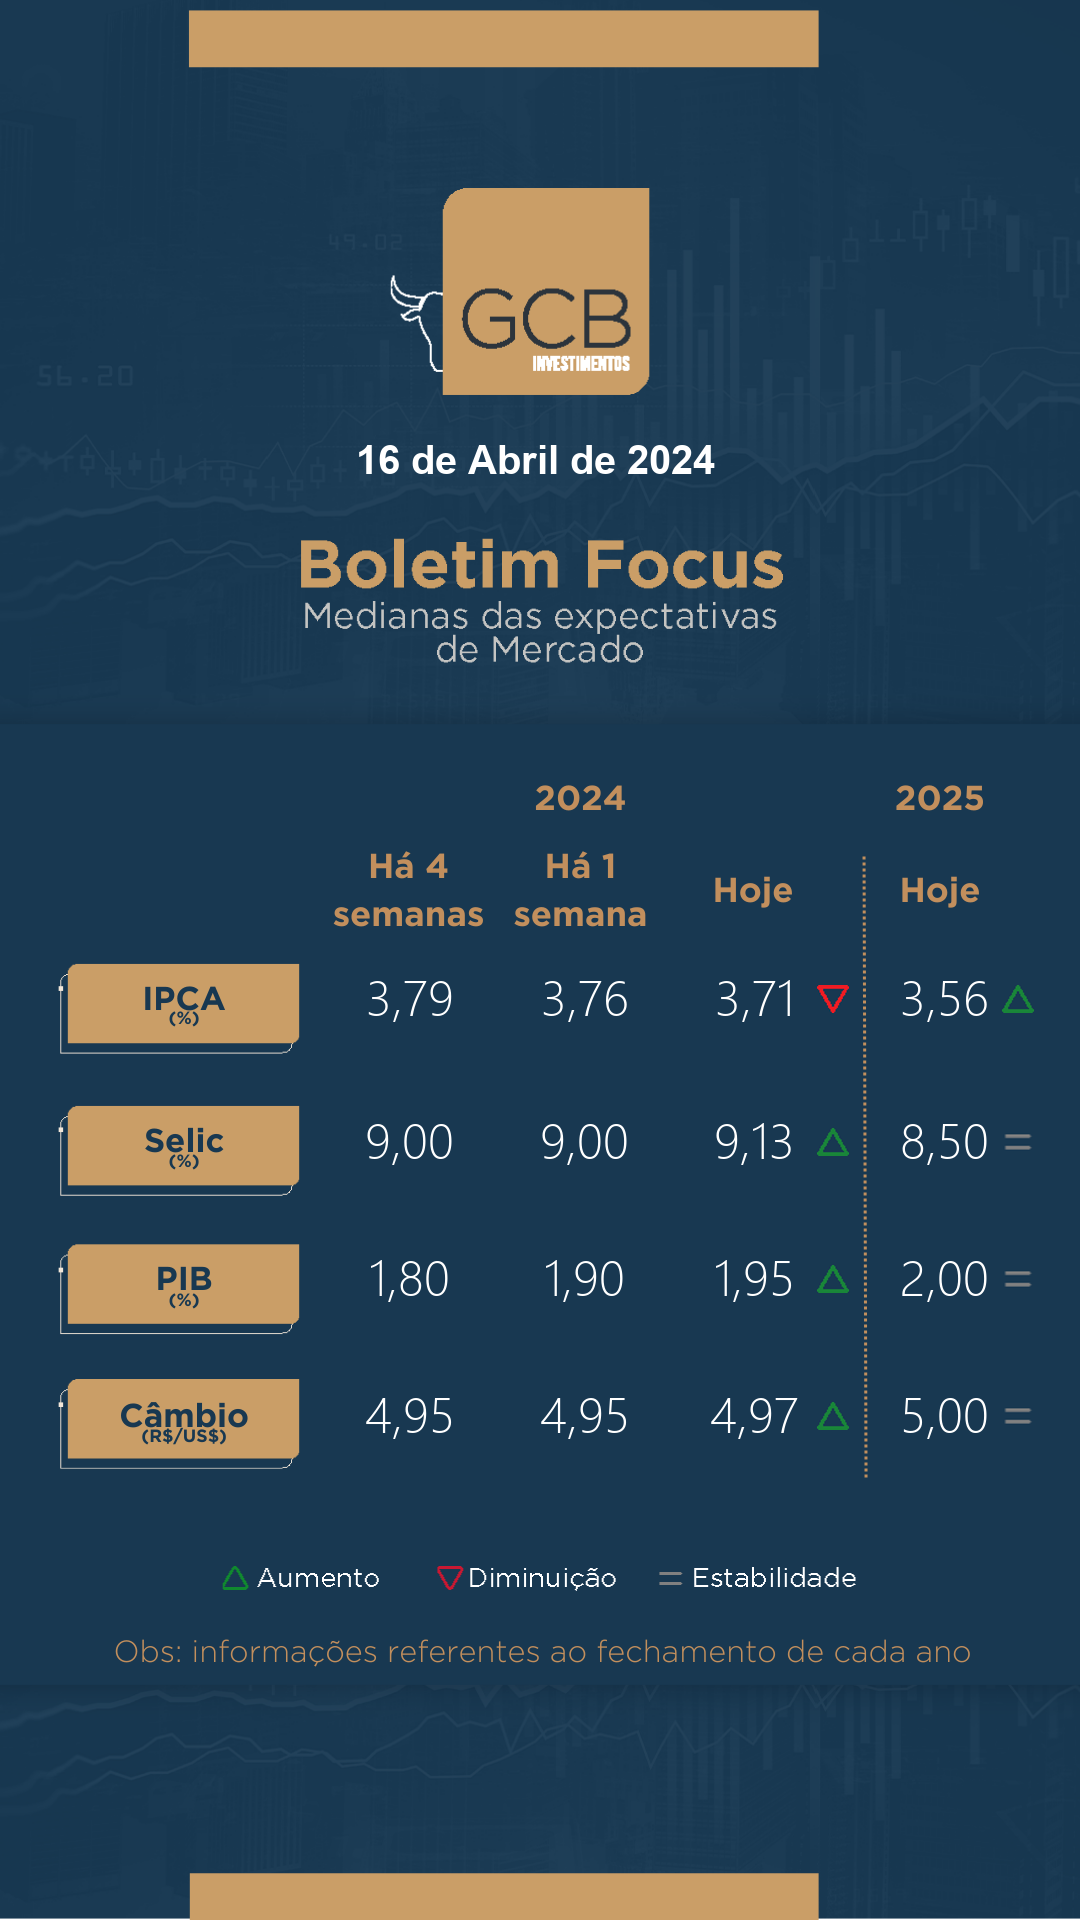

In [13]:
img = img.convert("RGB")
img.save(saving_path + r'\Focus\focus_' + last_friday + '.png')
img